In [1]:
import json 
import numpy as np
import matplotlib.pyplot as plt
import glob 
from dataclasses import dataclass
import pandas as pd


In [2]:
dirs = [
    "/scratch/gpfs/bs6865/messi-thinking/taco_instruct_llama_8b_single_slerp_0.7",
    "/scratch/gpfs/bs6865/messi-thinking/taco_instruct_llama_8b_single",
    "/scratch/gpfs/vv7118/projects/messi-thinking/llama-3.1-8b",
    # "/scratch/gpfs/vv7118/projects/messi-thinking/embeddings/taco_instruct_llama_8b_single",
    "/scratch/gpfs/bs6865/messi-thinking/taco_instruct_llama_8b_single_slerp_0.5",
    # "/scratch/gpfs/vv7118/projects/messi-thinking/embeddings/taco_instruct_llama_8b_single_slerp_0.90"
    ]

In [3]:
@dataclass 
class ModelGeneration:
    model_path: str 
    question_num: int
    sample_num: int
    generation: str 
    correctness: bool
    correctness_reason: str


def load_generations(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

    return ModelGeneration(
        model_path=file_path.split('/')[-2],
        question_num=data['question_id'],
        sample_num=data['sample_index'],
        generation=data['converted_text'],
        correctness=data['correctness'],
        correctness_reason=data['correctness_reason'],
        # embedding=data['generated_embedding']
    )

# model_names = [ 'taco_instruct_llama_8b_single_slerp_0.7','taco_instruct_llama_8b_single_slerp_0.90', 'llama-3.1-8b', 'taco_instruct_llama_8b_single']# 'taco_instruct_llama_8b_single_slerp_0.90']
# 'taco_instruct_llama_8b_single', 'taco_instruct_llama_8b_single_slerp_0.5'
generations = []

for model_path in dirs:
    # model_path = f"/scratch/gpfs/vv7118/projects/messi-thinking/embeddings/{model_name}"
    model_name = model_path.split('/')[-1]
    model_files = glob.glob(f"{model_path}/converted_*.json")
    model_files = [f for f in model_files if 'wrong_model' not in f]
    for file_path in model_files:
        try: 
            generations.append(load_generations(file_path))
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
            # raise e



In [13]:
df = pd.DataFrame(generations)

In [14]:
df.loc[df['correctness_reason'] == '', 'correctness_reason'] = 'correct'

In [15]:
df = df[df['question_num'] < 1000]
df = df[df['sample_num'] < 11]

In [18]:
correct = df[df['correctness_reason'] == 'correct']

In [20]:
correct.groupby('model_path')['generation'].apply(len).sort_values(ascending=False)

model_path
taco_instruct_llama_8b_single              3270
taco_instruct_llama_8b_single_slerp_0.7    2498
taco_instruct_llama_8b_single_slerp_0.5    1628
llama-3.1-8b                               1047
Name: generation, dtype: int64

In [29]:
data = df.groupby(['model_path','correctness_reason']).correctness.count().reset_index()
# data = data[data['correctness_reason'] != 'correct']
data['correctness'] =data['correctness'] / data.groupby('model_path')['correctness'].transform('sum')  

print(data.to_latex(index=False))

\begin{tabular}{llr}
\toprule
model_path & correctness_reason & correctness \\
\midrule
llama-3.1-8b & Code is incorrect. & 0.339100 \\
llama-3.1-8b & Does not contain code component. & 0.556200 \\
llama-3.1-8b & correct & 0.104700 \\
taco_instruct_llama_8b_single & Code is incorrect. & 0.568300 \\
taco_instruct_llama_8b_single & Does not contain code component. & 0.104700 \\
taco_instruct_llama_8b_single & correct & 0.327000 \\
taco_instruct_llama_8b_single_slerp_0.5 & Code is incorrect. & 0.537300 \\
taco_instruct_llama_8b_single_slerp_0.5 & Does not contain code component. & 0.299900 \\
taco_instruct_llama_8b_single_slerp_0.5 & correct & 0.162800 \\
taco_instruct_llama_8b_single_slerp_0.7 & Code is incorrect. & 0.583900 \\
taco_instruct_llama_8b_single_slerp_0.7 & Does not contain code component. & 0.166300 \\
taco_instruct_llama_8b_single_slerp_0.7 & correct & 0.249800 \\
\bottomrule
\end{tabular}



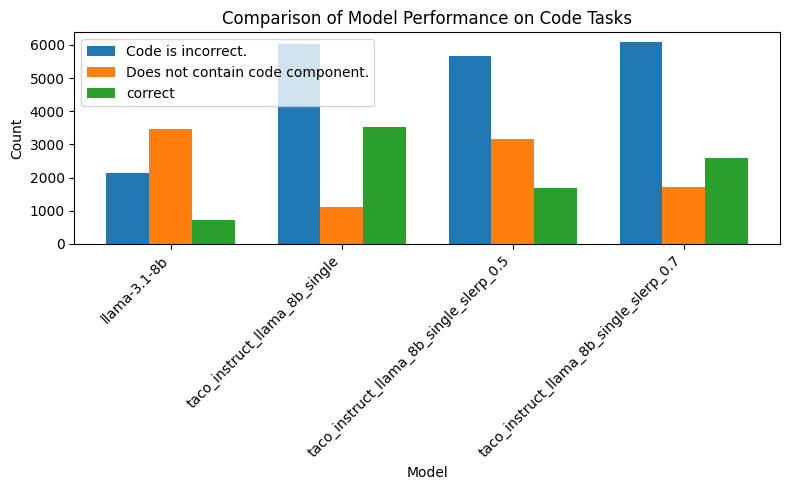

In [170]:
import matplotlib.pyplot as plt
import numpy as np

# Extract unique model names and categories
models = sorted(set(model for model, _ in data.keys()))
categories = ['Code is incorrect.', 'Does not contain code component.', 'correct']

# Prepare data for plotting
x = np.arange(len(models))  # X-axis positions for groups
width = 0.25  # Width of each bar

# Get values for each category
values = {category: [data.get((model, category), 0) for model in models] for category in categories}

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
for i, category in enumerate(categories):
    ax.bar(x + i * width, values[category], width, label=category)

# Formatting
ax.set_xlabel('Model')
ax.set_ylabel('Count')
ax.set_title('Comparison of Model Performance on Code Tasks')
ax.set_xticks(x + width)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.savefig('error_analysis.pdf', bbox_inches='tight')
plt.show()

In [30]:
df['id'] = df['question_num'].astype(str) + '_' + df['sample_num'].astype(str)

In [31]:
ids = df[df['model_path'] == 'taco_instruct_llama_8b_single']['id'].unique()
# df = df[df['id'].isin(ids)]

In [32]:
df.groupby(['model_path','question_num'])['sample_num'].sum().reset_index().groupby('model_path')['sample_num'].mean()

model_path
llama-3.1-8b                               45.0
taco_instruct_llama_8b_single              45.0
taco_instruct_llama_8b_single_slerp_0.5    45.0
taco_instruct_llama_8b_single_slerp_0.7    45.0
Name: sample_num, dtype: float64

In [33]:
files = glob.glob('../llama-3.1-8b/question*.json')

In [16]:
def extract_question_and_sample(file_path):
    question_num = file_path.split('question_')[-1].split('_')[0]
    sample_num = file_path.split('sample_')[-1].split('.json')[0]
    return question_num, sample_num

dd = []
for file in files:
    question_num, sample_num = extract_question_and_sample(file)
    dd.append([question_num, sample_num])


In [19]:
dd = pd.DataFrame(dd)
dd[dd[0].astype(int) < 1000].drop_duplicates()

,0,1
0,39,1
1,814,5
2,898,5
3,787,8
4,853,2
...,...,...
10296,717,8
10297,220,8
10298,248,0
10299,564,6


In [34]:
any_df = df.groupby(['model_path','question_num']).correctness.max().reset_index()

In [35]:
name_mapping = {
    "taco_instruct_llama_8b_single": r"$\alpha=1$",
    # "taco_instruct_llama_8b_single_slerp_0.90": r"$\alpha=0.9$",
    "taco_instruct_llama_8b_single_slerp_0.7": r"$\alpha=0.7$",
    "taco_instruct_llama_8b_single_slerp_0.5": r"$\alpha=0.5$",
    'llama-3.1-8b': r"$\alpha=0$",
}

Error getting SE for 8: single positional indexer is out-of-bounds
Error getting SE for 9: single positional indexer is out-of-bounds


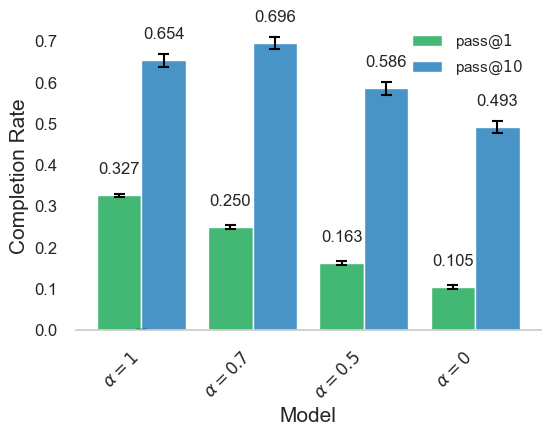

In [46]:
import seaborn as sns

# Set the style and LaTeX rendering
plt.style.use('seaborn-v0_8')
sns.set_theme(style='whitegrid')





# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Computer Modern Roman"],
# })

# Create figure with larger size
plt.figure(figsize=(6, 4))


model_order = [r"$\alpha=1$",  r"$\alpha=0.7$", r"$\alpha=0.5$", r"$\alpha=0$"]

# Calculate means and standard deviations with standard error
stats_df = df.groupby('model_path')['correctness'].agg(['mean', 'std', 'count'])
stats_any_df = any_df.groupby('model_path')['correctness'].agg(['mean', 'std', 'count'])

# Calculate standard error
stats_df['se'] = stats_df['std'] / np.sqrt(stats_df['count'])
stats_any_df['se'] = stats_any_df['std'] / np.sqrt(stats_any_df['count'])

# Create a new dataframe for plotting
plot_data = pd.DataFrame({
    'Model': [name_mapping.get(model, model) for model in stats_df.index] + 
            [name_mapping.get(model, model) for model in stats_any_df.index],
    'Correctness': list(stats_df['mean']) + list(stats_any_df['mean']),
    'SE': list(stats_df['se']) + list(stats_any_df['se']),
    'Type': ['pass$@1$']*len(stats_df) + ['pass$@10$']*len(stats_any_df)
})

# Create the grouped bar plot
ax = sns.barplot(
    data=plot_data,
    x='Model', 
    y='Correctness',
    hue='Type',
    palette=['#2ecc71', '#3498db'],
    order=model_order,
    errorbar=None,  # Disable seaborn's built-in error bars
)

# Add custom error bars
for i, bar in enumerate(ax.patches):
    x = bar.get_x() + bar.get_width()/2
    y = bar.get_height()
    try: 
        se = plot_data.iloc[i]['SE']
    except Exception as e: 
        print(f"Error getting SE for {i}: {e}")
        se = 0
    ax.vlines(x, y-se, y+se, color='black', linewidth=1.5)
    ax.hlines(y+se, x-0.05, x+0.05, color='black', linewidth=1.5)  # Top cap
    ax.hlines(y-se, x-0.05, x+0.05, color='black', linewidth=1.5)  # Bottom cap

ax.grid(False)
ax.set_facecolor('white')

# Customize the plot
plt.xlabel('Model', fontsize=15)
plt.ylabel('Completion Rate', fontsize=15)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for container in ax.containers:
    if type(container).__name__ == 'BarContainer':  # Only label the bars
        ax.bar_label(container, fmt='%.3f', padding=13)

# Adjust legend
plt.legend(bbox_to_anchor=(0.99, 1.01), loc='upper right')

# # Adjust layout to prevent label cutoff
# plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tick_params(axis='both', which='both', labelsize=12)

# Save and show the plot
plt.savefig('correctness_plot.pdf', bbox_inches='tight')
plt.show()

In [76]:
df.groupby(['model_path'])['question_num'].nunique()

model_path
llama-3.1-8b                                1000
taco_instruct_llama_8b_single               1000
taco_instruct_llama_8b_single_slerp_0.7     1000
taco_instruct_llama_8b_single_slerp_0.90    1000
Name: question_num, dtype: int64

In [77]:
# Get all question numbers for each model
model_questions = df.groupby('model_path')['question_num'].unique()

# Create set of all numbers 0-999
all_nums = set(range(1000))

# Find missing numbers for each model
for model in df['model_path'].unique():
    model_nums = set(model_questions[model])
    missing = sorted(all_nums - model_nums)
    print(f"\n{model}:")
    print(f"Missing {len(missing)} questions:")
    print(missing)



taco_instruct_llama_8b_single_slerp_0.7:
Missing 0 questions:
[]

taco_instruct_llama_8b_single_slerp_0.90:
Missing 0 questions:
[]

llama-3.1-8b:
Missing 0 questions:
[]

taco_instruct_llama_8b_single:
Missing 0 questions:
[]


In [37]:
# df = df[df['sample_num'] < 6]
# set default matplotlib style
sns.reset_orig()


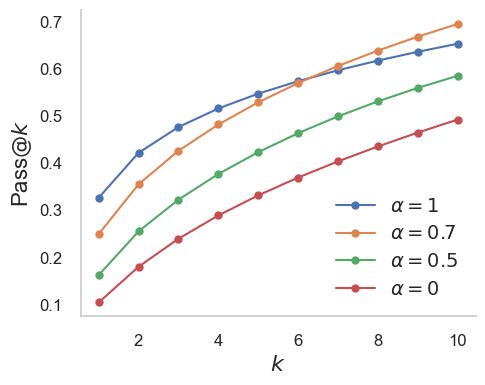

In [48]:
def calculate_pass_at_k(generations_df, model_name, k_values):
    """Calculate pass@k for a specific model using the estimator."""
    # Group by question_num to get all attempts and correct counts for each question
    grouped = generations_df[generations_df['model_path'] == model_name].groupby('question_num')
    
    pass_at_k = []
    for k in k_values:
        # For each question, get total samples and number of correct solutions
        stats = grouped.agg({
            'sample_num': 'count',  # Total samples per question
            'correctness': 'sum'    # Number of correct solutions per question
        })
        # Estimate pass@k using the estimator function
        estimates = estimate_pass_at_k(stats['sample_num'].values, stats['correctness'].values, k)
        pass_rate = estimates.mean()  # Average across all questions
        pass_at_k.append(pass_rate)
    
    return pass_at_k

import itertools
def estimate_pass_at_k(num_samples, num_correct, k):
    """Estimates pass@k of each problem and returns them in an array."""

    def estimator(n: int, c: int, k: int) -> float:
        """Calculates 1 - comb(n - c, k) / comb(n, k)."""
        if n - c < k:
            return 1.0
        return 1.0 - np.prod(1.0 - k / np.arange(n - c + 1, n + 1))

    if isinstance(num_samples, int):
        num_samples_it = itertools.repeat(num_samples, len(num_correct))
    else:
        assert len(num_samples) == len(num_correct)
        num_samples_it = iter(num_samples)

    return np.array([estimator(int(n), int(c), k) for n, c in zip(num_samples_it, num_correct)])

# Define k values to evaluate
k_values = range(1, df.groupby('question_num')['sample_num'].nunique().min() + 1)

# Plot settings
plt.figure(figsize=(5, 4))
sorted_models = sorted(df['model_path'].unique(), key=lambda x: name_mapping.get(x, x), reverse=True)

# Calculate and plot pass@k for each model
for model_name in sorted_models:
    # if model_name == 'llama-3.1-8b':
    #     pass_rates = calculate_pass_at_k(df, model_name, range(1, 6))
    #     pass_rates =  pass_rates + [0.1,0.1,0.1,0.1,0.1]
    # else:   
    pass_rates = calculate_pass_at_k(df, model_name, k_values)
    plt.plot(k_values, pass_rates, marker='o', label=name_mapping.get(model_name, model_name))

plt.xlabel('$k$', fontsize=16)
plt.ylabel('Pass$@k$', fontsize=16)
# plt.title('Pass@k for Different Models')
plt.legend(loc='lower right', fontsize=14)
plt.tight_layout()
plt.grid(False)
# remove spines 
plt.tick_params(axis='both', which='both', labelsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('pass_at_k.pdf', bbox_inches='tight', dpi=300)
plt.show()

